In [22]:
from sklearn import linear_model
import math
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pickle
import pandas as pd
from scipy.stats import norm
from scipy.optimize import least_squares


def bazin(time, A, B, t0, tfall, trise):
    X = np.exp(-(time - t0) / tfall) / (1 + np.exp((time - t0) / trise))
    return A * X + B

def lightcurve_fit(time, flux):
    scaled_time = time - time.min()
    t0 = scaled_time[flux.argmax()]
    guess = (0, 0, t0, 40, -5)
    errfunc = lambda params: abs(flux - bazin(scaled_time, *params))
    result = least_squares(errfunc, guess, method='lm')
    return result.x

def predict (x, deg, coef):
    p = 1
    result = 0
    for i in range(deg + 1):
        result += p*coef[deg-i]
        p = p*x
    return result
def predicts (x_vect, deg, coef):
    result = []
    for x in x_vect:
        result.append(predict(x, deg, coef))
    return result

def error(y1, y2):
    a = 0
    for i in range(len(y1)):
        a += (y1[i]-y2[i])**2
    return math.sqrt(a)

filename = "data1/des_train_mini.pkl"
data = None
with gzip.open(filename, 'rb') as f:
    data = pickle.load(f)

deg = 3
errors = pd.Series({'g_flux':0,'r_flux':0,'i_flux':0,'z_flux':0, 'g_fluxe':0,'r_fluxe':0,'i_fluxe':0,'z_fluxe':0})
stats = pd.DataFrame(({'g':[],'r':[],'i':[],'z':[]}))
l = len(data)
erreurs = pd.DataFrame()
x1, x21, y11, y21 = None, None, None, None
Y, Ye = None, None
mie, miv = 1e30000, 1e3000


x13, x213, y113, y213 = None, None, None, None
Y3, Ye3 = None, None
mie3, miv3 = 0, 0

a = 0
for idx in data:
    t = pd.Series()
    sd =  pd.Series()#{'g_flux':0,'r_flux':0,'i_flux':0,'z_flux':0, 'g_fluxe':0,'r_fluxe':0,'i_fluxe':0,'z_fluxe':0})
    try:
        for band in 'griz':
            d = data[idx][band]
            x_train = np.array(d['mjd'])
            t[band] = len(x_train)
            x = x_train
            #x_train = x_train.reshape(-1, 1)
            y_traine = np.array(d['fluxcalerr'])
            y_train = np.array(d['fluxcal'])

            #fit = lightcurve_fit(x_train, y_train)
            #fite = lightcurve_fit(x_train, y_traine)
            #v = bazin(stim2, *fit)
            #e = bazin(stim2, *fite)
            ab = np.polyfit(x_train, y_train, deg = deg)
            bb = np.polyfit(x_train, y_traine, deg = deg)
            
            """
            #model linear
            regr = linear_model.LinearRegression()
            regre = linear_model.LinearRegression()
            regr.fit(x_train, y_train)
            regre.fit(x_train, y_traine)
            """
            #y1, y2 = regr.predict(x_train), regre.predict(x_train)
            #y1, y2 = bazin(x_train - x_train.min(),*fit), bazin(x_train - x_train.min(),*fite)
            y1, y2 = predicts(x_train, deg, ab), predicts(x_train, deg, bb)
            ve = error(y1, y_train)
            ee = error(y2, y_traine)
            if ve < miv:
                x1 = x
                y11 = y1
                Y = y_train
                miv = ve
            if ee < mie:
                x21 = x
                y21 = y2
                Ye = y_traine
                mie = ee

            if ve > miv3:
                x13 = x
                y113 = y1
                Y3 = y_train
                miv3 = ve
            if ee > mie3:
                x213 = x
                y213 = y2
                Ye3 = y_traine
                mie3 = ee   
            errors[band+"_flux"] = errors[band+"_flux"] + ve
            errors[band+"_fluxe"] = errors[band+"_fluxe"] + ee
            sd[band+"_flux"] = ve
            sd[band+"_fluxe"] = ee
    except:
        a = a + 1
    stats = stats.append(t, ignore_index = True)
    erreurs = erreurs.append(sd, ignore_index = True)
    #break
print(a)

print(l)
print(errors) 
#print(stats)
print(erreurs)
errors.to_csv("errors_poly3.csv")
#stats.to_csv("stats.csv")
erreurs.to_csv("erreurs_poly3.csv")


plt.plot(x1, Y, 'o')
plt.plot(x1, y11)
plt.title(band)
plt.savefig("imgvalue_poly3.png")
plt.show()
plt.plot(x21, Ye, 'o')
plt.plot(x21, y21)
plt.title(band+"e")
plt.savefig("imgerreur_poly3.png")
plt.show()


plt.plot(x13, Y3, 'o')
plt.plot(x13, y113)
plt.title(band)
plt.savefig("imgvaluemax_poly3.png")
plt.show()
plt.plot(x213, Ye3, 'o')
plt.plot(x213, y213)
plt.title(band+"e")
plt.savefig("imgerreurmax_poly3.png")
plt.show()#"



0
300
g_flux     21538
r_flux     22322
i_flux     22503
z_flux     18615
g_fluxe     6848
r_fluxe     3010
i_fluxe     4121
z_fluxe     3379
dtype: int64
         g_flux    g_fluxe      i_flux    i_fluxe      r_flux    r_fluxe  \
0     39.432071  34.016879   21.561253  12.821849   17.588945  10.274587   
1     11.003387   5.668156   20.996880   3.076891   22.245347   1.937104   
2    109.187628  35.101592  129.236273  12.704664  149.590423  10.296427   
3     56.208222  27.756921   67.951332  24.654397   36.221442  13.562841   
4    150.913177  21.961650   82.606680   8.597849   94.839835   5.022493   
5     81.590253  21.858600   69.653518   9.875740   53.810635   5.552028   
6     39.591715  21.701772   32.792606   9.992539   30.109327   5.723628   
7     41.555263  26.480123   32.659705  24.072549   22.556649  13.064212   
8     30.376308  10.021865   58.432971   7.998127   59.890603   3.465707   
9     55.064445   8.723854   53.187189   2.263532   48.647779   2.260320   
10     1.

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [24]:
means = pd.Series()
stds = pd.Series()
means1 = pd.Series()
stds1 = pd.Series()

for ind in stats.columns:
    means[ind] = np.mean(stats[ind])
    stds[ind] = np.std(stats[ind])
for ind in erreurs.columns:
    means1[ind] = np.mean(erreurs[ind])
    stds1[ind] = np.std(erreurs[ind])
print("statistques:")
print("mean: ")
print(means)
print("std: ")
print(stds)
print("erreurs: \n")
print("mean: \n")
print(means1)
print("std: \n")
print(stds1)

statistques:
mean: 
g    21.290000
r    20.766667
i    20.250000
z    19.703333
dtype: float64
std: 
g    8.854334
r    8.687091
i    8.332317
z    8.195242
dtype: float64
erreurs: 

mean: 

g_flux     72.284646
g_fluxe    23.300466
i_flux     75.529439
i_fluxe    14.243250
r_flux     74.896889
r_fluxe    10.531774
z_flux     62.541965
z_fluxe    11.774975
dtype: float64
std: 

g_flux     105.169204
g_fluxe     15.355964
i_flux      83.016597
i_fluxe     12.217352
r_flux     102.101572
r_fluxe     10.894790
z_flux      65.065822
z_fluxe     10.350860
dtype: float64


In [ ]:
find and display all time and after put the data in same grid.

In [38]:
from sklearn import linear_model
import math
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pickle
import pandas as pd
from scipy.stats import norm
from scipy.optimize import least_squares

filename = "data1/des_train_mini.pkl"
filetest = "data1/des_test_mini.pkl"

data_train = None
data_test = None
with gzip.open(filename, 'rb') as f:
    data_train = pickle.load(f)
with gzip.open(filetest, 'rb') as f:
    data_test = pickle.load(f)
result = pd.Series()
data = [data_train, data_test]
for dd in data:
    for idx in dd:
        for band in 'griz':
            d = dd[idx][band]
            x_train = np.array(d['mjd'])
            for val in x_train:
                try:
                    result[str(val)] = result[str(val)] + 1
                except:
                    result[str(val)] = 1
print(len(result)) 
print(result)
np.save("data/grid_mini_time", np.array(result.index, dtype = float))
result.to_csv("data/grid_mini_time.csv")

                    

636
56177.172     55
56179.172     56
56187.156     62
56189.148     63
56194.121     68
56207.156     78
56215.164     83
56221.062     86
56222.047     88
56228.031     92
56229.031     92
56230.035     94
56231.035     95
56235.145     96
56236.16      98
56237.176     99
56238.188     99
56243.203    102
56244.18     103
56245.191    104
56246.234    104
56248.207    105
56258.242    112
56261.215    111
56274.16     121
56282.16     122
56177.188     55
56179.312     56
56187.172     62
56189.16      63
            ... 
56235.02      75
56237.023     75
56243.07      79
56245.027     80
56247.25      80
56258.191     82
56312.055     78
56320.043     76
56328.047     72
56336.062     68
56345.039     60
56350.023     56
56312.066     78
56320.051     76
56328.055     72
56336.082     68
56345.055     60
56350.027     56
56312.09      78
56320.059     76
56328.07      72
56337.062     68
56346.055     59
56350.035     56
56312.113     78
56320.07      76
56328.086     72
56337.078 

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pickle
import pandas as pd
from scipy.stats import norm
from scipy.optimize import least_squares


def reshape(time):
    X = []
    for i in time:
        X.append([i])
    return np.array(X)


def estimate_gaussian(stime, x_train, y_train):
    gp = GaussianProcessRegressor()#n_restarts_optimizer=9)
    X = reshape(x_train)
    gp.fit(X, y_train)
    stime = reshape(stime)
    return np.array(gp.predict(stime, return_std=False))

def bazin(time, A, B, t0, tfall, trise):
    X = np.exp(-(time - t0) / tfall) / (1 + np.exp((time - t0) / trise))
    return A * X + B

def lightcurve_fit(time, flux):
    scaled_time = time - time.min()
    t0 = scaled_time[flux.argmax()]
    guess = (0, 0, t0, 40, -5)
    errfunc = lambda params: abs(flux - bazin(scaled_time, *params))
    result = least_squares(errfunc, guess, method='lm')
    return result.x


def predict (x, deg, coef):
    p = 1
    result = 0
    for i in range(deg + 1):
        result += p*coef[deg-i]
        p = p*x
    return result
def predicts (x_vect, deg, coef):
    result = []
    for x in x_vect:
        result.append(predict(x, deg, coef))
    return result

timeGrid = "data/grid_mini_time.npy"
filename = "data1/des_train_mini.pkl"
data = None

time_values = (np.load(timeGrid))#[0:50]
with gzip.open(filename, 'rb') as f:
    data = pickle.load(f)
deg = 3
result = pd.DataFrame()
aaa = 0
for idx in data:
    loc = pd.Series()
    for band in 'griz':
        d = data[idx][band]
        x_train = np.array(d['mjd'])
        y_traine = np.array(d['fluxcalerr'])
        y_train = np.array(d['fluxcal'])
        ab = np.polyfit(x_train, y_train, deg = deg)
        bb = np.polyfit(x_train, y_traine, deg = deg)
        value = ""
        error = ""
        loc['clas'] = (data[idx]['header'])['type']
        for time in time_values:
            try:
                pos = x_train.tolist().index(time)
                value = value+";"+str(y_train[pos])
                error = error+";"+str(y_traine[pos])
            except:
                Y, Ye= predict(time, deg, ab), predict(time, deg, bb)
                value = value+";"+str(Y)
                error = error+";"+str(Ye)
        loc[band] = value[1:]
        loc[band+"_err"] = error[1:]
    result = result.append(loc, ignore_index = True)
result.to_csv("data/train_mini_poly3.csv", index = False)
print("ok ...")

ok ...


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import math


def z_norm(ST = [1, 2, 3, 4, 5]):
    mu = np.mean(ST)
    std = np.std(ST)
     #print(mu, std)
    if std == 0:
        A = [0 for i in ST]
    else:
        A = [(st-mu)/std for st in ST]
    return np.array(A)

def PAA(ST, dim):
    coef = dim/len(ST)
    vals = []
    i = 0
    while i<dim:
        a = (len(ST)*(i+1))//dim
        ci = np.sum([v for v in ST[i:a]])*coef
        i = i + 1
        vals.append(ci)
    return np.array(vals)

def  sax (ts, n_pieces = 16, alphabet = 4):
    t_al = alphabet
    alphabet = []
    for i in range(t_al):
        alphabet.append(i)
    alphabet_sz = len(alphabet)
    thrholds = norm.ppf(np.linspace(1./alphabet_sz,
                                    1-1./alphabet_sz,
                                    alphabet_sz-1))
    def translate(ts_values):
        return np.asarray([(alphabet[0] if ts_value < thrholds[0]
                else (alphabet[-1] if ts_value > thrholds[-1]
                      else alphabet[np.where(thrholds <= ts_value)[0][-1]+1]))
                           for ts_value in ts_values])
    paa_ts = PAA(z_norm(ts), n_pieces)
    result = np.apply_along_axis(translate, 0, paa_ts)
    return toString(result, "")

def sax_all(D, dim = 16, word_size = 4):
    result = []
    for x in D:
        result.append(sax(x, dim, word_size))
    return np.array(result)

def In_Binary_Data(D, Y, dim = 8, word_size = 4, sax_len = 8, band_sax = '10030#1$2$3', band = 'g'):
    result = pd.DataFrame()
    l = sax_len
    print('starting for computing')
    ab, ac = 0, 0
    for i in range(len(D)):
        T = D[i]
        a = 0
        vect = pd.Series()
        if Y[i] == 0:
            vect['clas'] = Y[i]
            ab = ab + 1
        else:
            vect['clas'] = 1
            ac = ac + 1
        for i in range(len(T)-l+1):
            x = T[i:i+l]
            sa = sax(x, dim, word_size)
            tab = band_sax.split('#')
            saxc = tab[0]
            indexes = np.array(tab[1].split('$'), dtype = int)
            #print(indexes)
            #print(saxc == '10030')
            sa_val = do_projection_one(sa, indexes)
            #print(sa_val)
            if sa_val == saxc :
                a = 1
                break
        vect[band] = a
        result = result.append(vect, ignore_index = True)
    print('end ...')
    print(ab, ac)
    return result
def generate_candidates_with_sax(D, Y, max_ = 20, min_ = 10, dim = 8, word_size = 4):
    result = []
    second = []
    l = max_
    nbA, nbB = 0, 0
    while l>=min_:
        for j in range(len(D)):
            T = D[j]
            a = []
            for i in range(len(T)-l+1):
                x = T[i:i+l]
                sa = sax(x, dim, word_size)
                result.append([x, sa])
                second.append([sa+"D"+str(j), Y[j]])
                a.append(sa)

            if Y[j] == 0:
                nbA = nbA + 1
            else:
                nbB = nbB + 1
        l = l - 1
    return result, second, nbA, nbB


def read_data(path , band, min_, max_):
    all = pd.read_csv(path)
    X, Y = [], []
    dataX = all[band]
    dataY = all["clas"]
    for i in range(len(dataX)):
        X.append(np.array(dataX[i].split(";"), dtype = float))
        Y.append(dataY[i])
    return X, Y

def choise(mask, ra):
    l = [a for a in ra]
    k = int(mask)
    r = []
    while k>0 and len(l)>0:
        k = k - 1
        np.random.shuffle(l)
        r.append(int(l[0]))
        l = l[1:len(l)]
    return np.array(r)

def toString(tab, sep = "$"):
    r = ""
    for a in range(len(tab)-1):
        r = r + str(tab[a]) + sep
    r = r+str(tab[len(tab)-1])
    return r

def do_projection(pop, indexes):
    result = []
    for c in pop:
        d = c[0]
        r = ""
        for i in range(len(d)):
            if not (i in indexes):
                r = r + str(d[i])
        result.append([r, c[1]])
    return result

def do_projection_one(c, indexes):
    r = ""
    for i in range(len(c)):
        if not (i in indexes):
            r = r + str(c[i])
    return r

def get_kbest_candidates(D, mask, tour, nbB, nbA, dim):
    is_ok = []
    ttt_ = None
    Mini = 1e30000
    print("starting candidates seeking...")
    for t in range(tour):
        masks = np.array(choise(mask, range(dim)))
        masks.sort()
        temp = str(masks)
        if temp in is_ok:
            continue
        else:
            is_ok.append(temp)
        pjts = do_projection(D, masks)
        tab, tabtemp = pd.DataFrame({}),  pd.Series()
        all_without = []
        for cd in pjts:
            try:
                tabtemp[cd[0]] = tabtemp[cd[0]] + 1
            except:
                r = cd[0].split("D")[0]
                tabtemp[cd[0]] = 1
                all_without.append([r+'#'+toString(masks), cd[1]])
        for c in all_without:
            e = c[0]
            if c[1] == 0:
                cla = c[1]
            else:
                cla = 1
            try:
                tab[e][cla] = tab[e][cla] + 1
            except:
                tab[e] = [0,0]
                tab[e][cla] = 1
        test = 0
        for key in tab.columns:
            if tab[key][0]<tab[key][1]:
                minim = nbB - tab[key][1] + tab[key][0] 
            elif tab[key][0]>tab[key][1]:
                 minim = nbA - tab[key][0] + tab[key][1] 
            else:
                if nbA > nbB:
                    minim = nbA
                else:
                    minim = nbB
            if minim < Mini:
                ttt_ = key
                Mini = minim
    st = 'erreur: ' + str(Mini) + ' shapelet: ' + str(ttt_)
    print(st)
    return [ttt_]
def do_mapping(tab_pair, candidates):
    all_ = []
    for c in candidates:
        c_ = c.split("#")
        candidate = c_[0]
        indexes = np.array(c_[1].split("$"), dtype = int)
        for t in tab_pair:
             if do_projection_one(t[1], indexes) == candidate:
                 all_.append(t[0])
                 #print(len(t[0]))
    return all_

#The main program

max_ = 30
min_ = 18
dim = 8
word_size = 4
tour = 30
mask = 2
band = 'r'

p = "data/"
path = "data/train_mini_poly3.csv"
X, Y = read_data(path,  band = band, min_ = min_, max_ = max_)
#In_Binary_Data(X, Y, dim = dim, word_size = word_size, sax_len = 30, band_sax = '3333#4$5$6$7', band = band).to_csv(p+'first_test8.csv', index = False)
print("starting ...")
result, second, nbA, nbB = generate_candidates_with_sax(X, Y, max_ = max_, min_ = min_, dim = dim, word_size = word_size)
print(len(second))
print("candidates generation ok")
candidates = get_kbest_candidates(second, mask, tour, nbB, nbA, dim)
print("best candidates finding ok")
cands = do_mapping(result, candidates)
print("mapping ok")
#print(cands)
np.save(p+"_cand_"+band, np.array(cands))

starting ...
2390700
candidates generation ok
starting candidates seeking...


In [ ]:
Affichage de la distribution des tailles de series

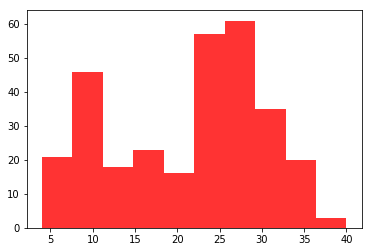

'    \nprint(len(result)) \nprint(result)\nnp.save("data/grid_mini_time", np.array(result.index, dtype = float))\nresult.to_csv("data/grid_mini_time.csv")\n'

In [4]:
"""
from sklearn import linear_model
import math
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pickle
import pandas as pd
from scipy.stats import norm
from scipy.optimize import least_squares

filename = "data1/des_train_mini.pkl"
filetest = "data1/des_test_mini.pkl"

data_train = None
data_test = None
with gzip.open(filename, 'rb') as f:
    data_train = pickle.load(f)
with gzip.open(filetest, 'rb') as f:
    data_test = pickle.load(f)
result = pd.Series()
data = [data_train, data_test]
for dd in data:
    for idx in dd:
        for band in 'griz':
            d = dd[idx][band]
            x_train = np.array(d['mjd'])
            for val in x_train:
                try:
                    result[str(val)] = result[str(val)] + 1
                except:
                    result[str(val)] = 1
print(len(result)) 
print(result)
np.save("data/grid_mini_time", np.array(result.index, dtype = float))
result.to_csv("data/grid_mini_time.csv")
"""
from sklearn import linear_model
import math
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pickle
import pandas as pd
from scipy.stats import norm
from scipy.optimize import least_squares

filename = "data1/des_train_mini.pkl"
filetest = "data1/des_test_mini.pkl"

data_train = None
data_test = None
with gzip.open(filename, 'rb') as f:
    data_train = pickle.load(f)
#with gzip.open(filetest, 'rb') as f:
    #data_test = pickle.load(f)
#result = pd.Series()
#data = [data_train, data_test]
#for dd in data:
r = []
for band in 'griz':
    temp = []
    for idx in data_train:
        d = data_train[idx][band]
        temp.append(len(np.array(d['mjd'])))
    r.append(temp)

plt.hist(np.array(r[0]),bins=10,color="red",alpha=0.8)
#plt.title("Histogramme avec 100 intervalles")
#plt.ylabel("Fréquences")
plt.show()


"""    
print(len(result)) 
print(result)
np.save("data/grid_mini_time", np.array(result.index, dtype = float))
result.to_csv("data/grid_mini_time.csv")
"""

In [41]:
from sklearn import linear_model
import math
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pickle
import pandas as pd
from scipy.stats import norm
from scipy.optimize import least_squares

filename = "data1/des_train_mini.pkl"
filetest = "data1/des_test_mini.pkl"

filenamet = "data1/des_train.pkl"
filetestt = "data1/des_test.pkl"

data_train = None
data_test = None
with gzip.open(filenamet, 'rb') as f:
    data_train = pickle.load(f)
r = pd.Series()
for idx in data_train:
    c = (data_train[idx]['header'])['type']
    try:
        r[str(c)] = r[str(c)]+1
    except:
        r[str(c)] = 1
#"""
k = r.sort_values(ascending = False)
print(k)
#"""

0     559
30     89
2      55
8      45
42     35
27     34
22     23
21     22
24     20
32     17
36     14
1      13
26     13
4      11
15     11
16     10
29     10
23     10
35      9
34      8
37      7
19      7
13      7
33      6
5       6
25      6
20      6
44      5
40      5
3       5
38      4
6       4
7       4
18      4
43      3
39      3
10      2
12      2
17      2
45      2
14      2
41      1
11      1
9       1
dtype: int64


In [ ]:
import numpy as np
import pandas as pd
import math 

def dist_eucl (s1, s2):
    dis = 0
    for i in range(len(s1)):
        dis += (s1[i]-s2[i])**2
    return dis
def distance_eucl(ts, shap):
    window = len(shap)
    dis = dist_eucl(shap, ts[0:window])
    for i in range(1,len(ts)-window + 1):
        temp = 0
        s2 = ts[i:i+window]
        j = 0
        again = True
        while j < len(shap) and again:
            temp += (s1[j]-ts[j])**2
            if temp>=dis:
                again = False
            j = j + 1
        if again:
            dis = temp
    return math.sqrt(dis)

#Le tab est une matrice de la forme [[distances avec class 0], [distances avec class 1], [distances avec class 2], ..., [distances avec class n]]
def gain(tab):
    result = []
    for x in tab:
        result.append(np.mean(x)-np.std(x))
    return np.std(result)

def generateCandidate(t, l):
    result = []
    for i in range(len(t)-l+1):
        result.append(t[i:i+t])
    return result

def AreTheSame(shap1, shap2):
    if len(shap1)>len(shap2):
        dis = distance_eucl(shap1, shap2)
    else:
        dis = distance_eucl(shap2, shap1)
    return (dis == 0)

def removeselfSimilar(shapelets):
    i = 0
    l1 = len(shapelets)-1
    while i<l1:
        j = i + 1
        l2 = len(shapelets)
        while j < l2:
            if AreTheSame(shapelets[i][0], shapelets[j][0]):
                del shapelets[j]
                l2 = len(shapelets)
            else:
                j +=j
        i += i
        l1 = len(shapelets)-1
    return shapelets

def findDistances(s, T):
    result = {}
    for ts in T:
        indice = ts[1]
        val = distance_eucl(ts[0], s)
        try:
            result[indice].append(val)
        except:
            result[indice] = [val]
    r = []
    for val in result.values():
        r.append(val)
    np.array(r)

#shapelets is in format of [(shap, gain),(), ..., ()]	
def sortByQuality(shapelets):
    for i in range(len(shapelets)-1):
        for j in range(i+1, len(shapelets)):
            if shapelets[i][1]<shapelets[j][1]:
                x = shapelets[i]
                shapelets[i] = shapelets[j]
                shapelets[j] = x
    return shapelets

def merge(k, kshapelets, shapelets):
    if kshapelets == [] :
        return np.array(shapelets[0:k]).tolist()
    b = 0
    result = []
    while b < k:
        if kshapelets[0][1]<shapelets[0][1]:
            result.append(shapelets[0])
            del shapelets[0]
        else:
            result.append(kshapelets[0])
            del kshapelets[0]
        b += b
    return result

# T = [[timeserie2, label],[timeserie1, label], ... [timeserien, label]]
def ShapeletCachedSelection(T, min, max, k):
    kshapelets = []
    for t in T:
        shapelets = []
        for l in range(min, max+1):
            W = generateCandidate(t, l)
            for s in W:
                #Ds format is as the tab(for gain parameter) format 
                Ds = findDistances(s, T)
                shapelets.append((s, gain(Ds)))
        shapelets = sortByQuality(shapelets)
        shapelets = removeselfSimilar(shapelets)
        kshapelets = merge(k, kshapelets, shapelets)
    return shapelets


def faster(  ):
    while data:
        index = random.randrange(len(data))
        elem = data[index]
        # direct deletion, no search needed
        del data[index] 
        process(elem)

def choise_randomly10(T):
    index = range(len(T))
    data = []
    rg = range(len(T))
    for i in range(len):
        ind = random.choice(rg)
        data.append(T[ind])
        del rg[ind]
    return data
def addOnShapelets(shapelets, currentShapelets):
    result = [x for x in shapelets]
    for x in currentShapelets:
        result.append(x)
    return result

def orderByLength(shapelets):
    result = []
    for a in shapelets:
        b = a[0]
        result.append(b)
        i = len(result)-2
        while i>=0:
            if result[i+1]<result[i]:
                aa = result[i+1] 
                result[i+1] = result[i]
                result[i] = aa
            else:
                break;
            i +=1
    return result
def estimateMinAndMax(T):
    shapelets = []
    length = len(T[0])
    for i in range(1,11):
        TT = choise_randomly10(T)
        currentShapelets = ShapeletCachedSelection(TT, 1, length, 10)
        shapelets = addOnShapelets(shapelets, currentShapelets)
    shapelets = orderByLength(shapelets)
    min_ = shapelets[25]
    max_ = shapelets[75]
    return min_, max_

def get_index(bands, band):
    for i in range(len(bands)):
        if band == bands[i]:
            return i
        
def load_from_npy(path, band = "g", bands = "griz"):
    D = np.load(path)
    T = []
    b = get_index(bands, band)
    for t in D:
        T.append([t[0][b], t[1]])
    return T

#loading data
#T = [[timeserie2, label],[timeserie1, label], ... [timeserien, label]]
path = "/home/peta/ouissa/data2/data/train_mini_poly.npy"
band = "g"
T = load_from_npy(path, band = band, bands = "griz")
print(len(T[0][]), T[0][1])
    

In [27]:
import numpy as np
serie = [0.5,1.0,0.5,1.0,0.5,1.0,0.5,1.0]
#a = np.fft.fft(serie)

def normal(T):
    std = np.std(T)
    if not(std == 0):
        mean = np.mean(T)
        for i in range(len(T)):
            T[i] = (T[i]-mean)/std
    return T

c=np.fft.fft(normal([1,2,3,45,7]))
print(c)
print(np.fft.fftfreq(8))

[ 0.        +0.j         -2.08345784+1.75003721j  0.50830767-2.19959008j
  0.50830767+2.19959008j -2.08345784-1.75003721j]
[ 0.     0.125  0.25   0.375 -0.5   -0.375 -0.25  -0.125]


In [ ]:
Modèle bazin et interpollation polynomiale

In [ ]:
import math
import numpy as np
import gzip
import pickle
import pandas as pd
from scipy.stats import norm
from scipy.optimize import least_squares


def bazin(time, A, B, t0, tfall, trise):
    X = np.exp(-(time - t0) / tfall) / (1 + np.exp((time - t0) / trise))
    return A * X + B

def lightcurve_fit(time, flux):
    scaled_time = time - time.min()
    t0 = scaled_time[flux.argmax()]
    guess = (0, 0, t0, 40, -5)
    errfunc = lambda params: abs(flux - bazin(scaled_time, *params))
    result = least_squares(errfunc, guess, method='lm')
    return result.x


def predict (x, deg, coef):
    p = 1
    result = 0
    for i in range(deg + 1):
        result += p*coef[deg-i]
        p = p*x
    return result
def predicts (x_vect, deg, coef):
    result = []
    for x in x_vect:
        result.append(predict(x, deg, coef))
    return result

what = "train"
filename = "/home/peta/ouissa/data/des_"+what+"_mini.pkl"

saving = "/home/peta/ouissa/data/param/"+what+".csv"
with gzip.open(filename, 'rb') as f:
    data = pickle.load(f)
deg = 3
result = pd.DataFrame()
lost = 0
for idx in data:
    try:
        loc = pd.Series()
        for band in 'griz':
            d = data[idx][band]
            x_train = np.array(d['mjd'])
            #y_traine = np.array(d['fluxcalerr'])
            y_train = np.array(d['fluxcal'])
            out1 = np.polyfit(x_train, y_train, deg = deg)
            out2 = lightcurve_fit(x_train, y_train)
            for i in range(len(out1)):
                loc[band+"_poly_"+str(i)] = out1[i]
            for i in range(len(out2)):
                loc[band+"_exp_"+str(i)] = out2[i]
            #bb = np.polyfit(x_train, y_traine, deg = deg)
            loc['clas'] = (data[idx]['header'])['type']
        result = result.append(loc, ignore_index = True)
    except:
    lost = lost + 1
print("Lost data: |"lost)
result.to_csv(saving, index = False)
print("ok ...")

In [ ]:
Utilisation juste du modèle bazin

In [ ]:
import math
import numpy as np
import gzip
import pickle
import pandas as pd
from scipy.stats import norm
from scipy.optimize import least_squares


def bazin(time, A, B, t0, tfall, trise):
    X = np.exp(-(time - t0) / tfall) / (1 + np.exp((time - t0) / trise))
    return A * X + B

def lightcurve_fit(time, flux):
    scaled_time = time - time.min()
    t0 = scaled_time[flux.argmax()]
    guess = (0, 0, t0, 40, -5)
    errfunc = lambda params: abs(flux - bazin(scaled_time, *params))
    result = least_squares(errfunc, guess, method='lm')
    return result.x


def predict (x, deg, coef):
    p = 1
    result = 0
    for i in range(deg + 1):
        result += p*coef[deg-i]
        p = p*x
    return result
def predicts (x_vect, deg, coef):
    result = []
    for x in x_vect:
        result.append(predict(x, deg, coef))
    return result

what = "train"
filename = "/home/peta/ouissa/data/des_"+what+".pkl"

saving = "/home/peta/ouissa/data/param/"+what+".csv"
with gzip.open(filename, 'rb') as f:
    data = pickle.load(f)
deg = 3
result = pd.DataFrame()
lost = 0
for idx in data:
    try:
        loc = pd.Series()
        for band in 'griz':
            d = data[idx][band]
            x_train = np.array(d['mjd'])
            #y_traine = np.array(d['fluxcalerr'])
            y_train = np.array(d['fluxcal'])
            #out1 = np.polyfit(x_train, y_train, deg = deg)
            out2 = lightcurve_fit(x_train, y_train)
            #for i in range(len(out1)):
                #loc[band+"_poly_"+str(i)] = out1[i]
            for i in range(len(out2)):
                loc[band+"_exp_"+str(i)] = out2[i]
            #bb = np.polyfit(x_train, y_traine, deg = deg)
            loc['clas'] = (data[idx]['header'])['type']
        result = result.append(loc, ignore_index = True)
    except:
    lost = lost + 1
print("Lost data: |"lost)
result.to_csv(saving, index = False)
print("ok ...")